In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
font = {'family': 'monospace', 'weight': 'medium', 'size': 13}

plt.rc('font', **font)
plt.rc('figure', figsize=(14, 8), dpi=300)

# **GOAL**

Predict the **MEDIAN HOUSE VALUE** in a given district using the provided dataset

### MACHINE LEARNING DESIGN

- **targets/label**: *Supervised Learning*

- **changing dataset ? - NO**: *Batch/offline learning*

- **too large dataset?-NO**: *not out-of-core learning*

In [3]:
# get the dataset

housing = pd.read_csv("../datasets/housing.csv")

housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
# get the info of the dataset

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### **OBSERVATIONS - 1**

- All Attributes are numerical except the ***ocean_proximity*** attribute

- There are missing values in the ***total_bedrooms*** column

---

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

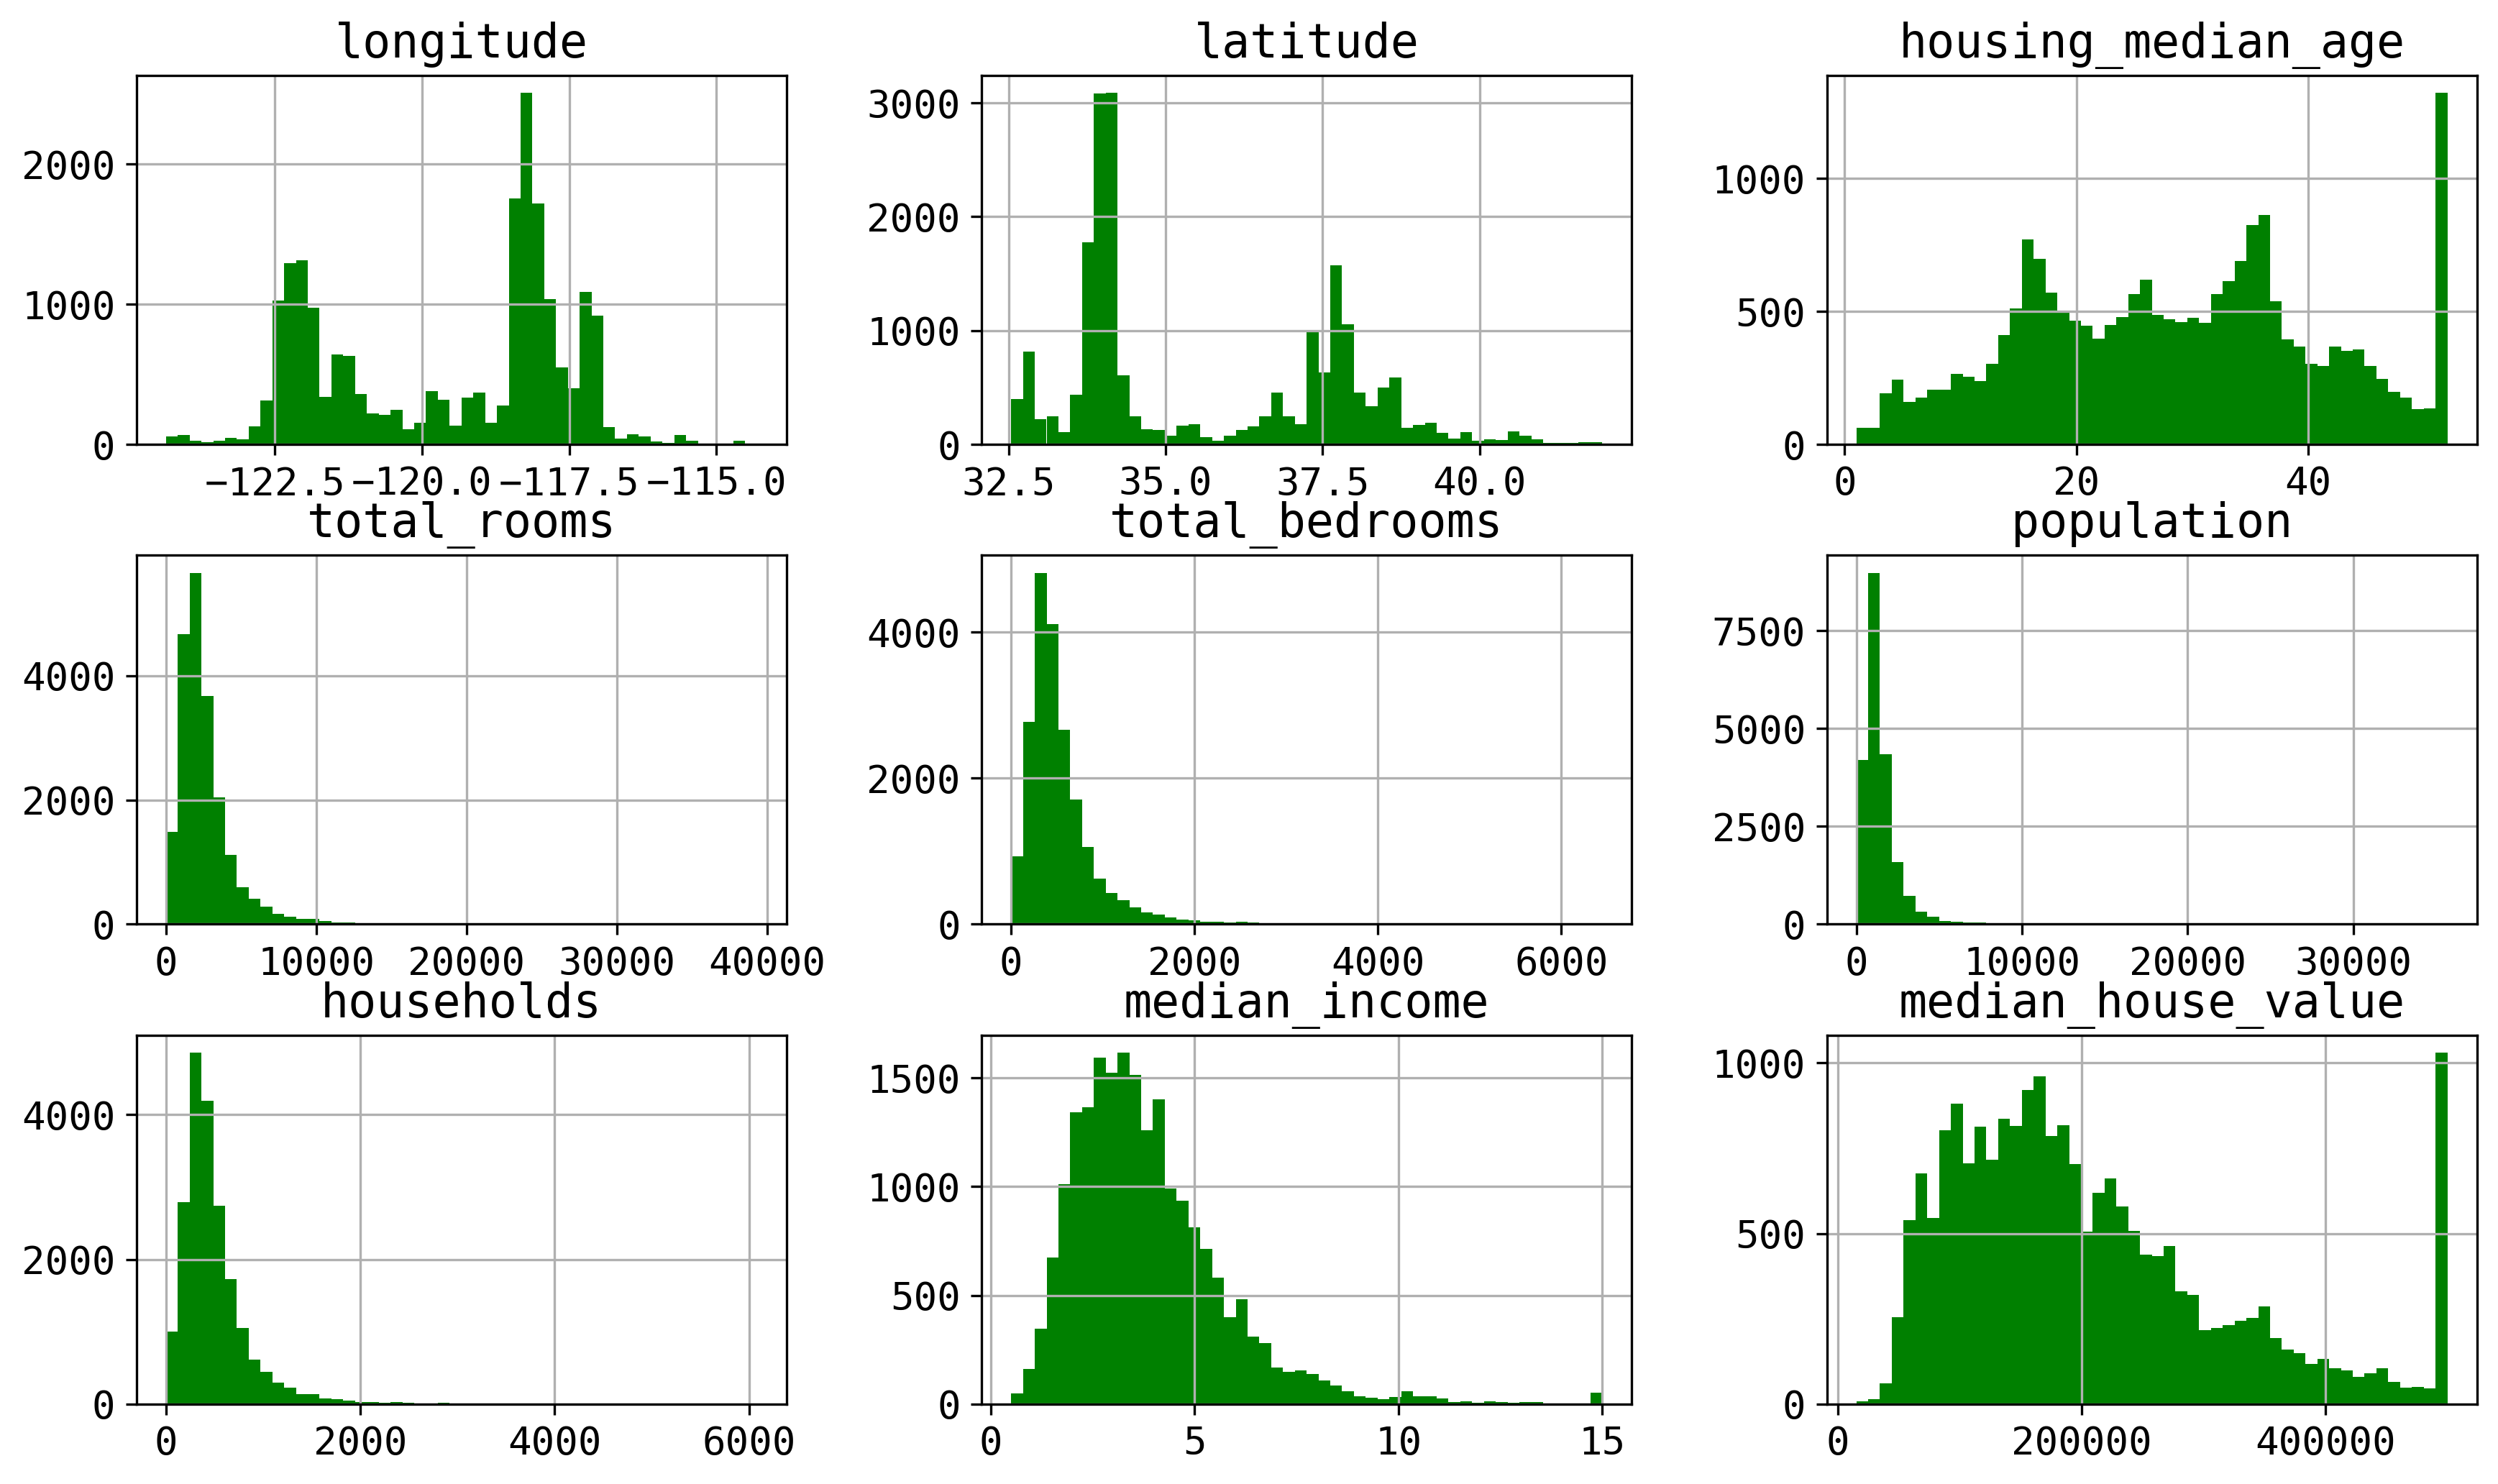

In [5]:
# visualize the dataset distribution

housing.hist(bins=50, grid=True, color='green')

### **OBSERVATION - 2**

- The following attributes (*total_rooms, total_bedrooms, population, housholds, median_income, median_house_value*) have their data skewed to the right, indicating that there are outliers in th dataset on the high side

- The **median_income** values have been scaled down by **ten-thousand dollars**, this indicates that the real value is ten-thousand times the given values

---

## **TRAINING & TEST DATASET**

We want the test set to be representative of the entire dataset, so as to avoid sampling bias which may result in poor generalization. Hence, we use stratified sampling.

However, we must decide on which attribute is the most correlated with the target we we want to predict, and then used that attribute to create a stratified sampling


In [6]:
# get the correlation of all attributes with respect to target

# get only numerical attributes
housing_num = housing.select_dtypes(np.number)

housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [7]:
# get the correlation matrix

housing_corr = housing_num.corr('pearson')

housing_corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

### **OBSERVATION - 3**

- *median_income* is more correlated with the target attribute.

- how do we stratify the values in the *media_income* column such that the resulting category is not too large?

In [8]:
housing_num.median_income.describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

<Axes: ylabel='Frequency'>

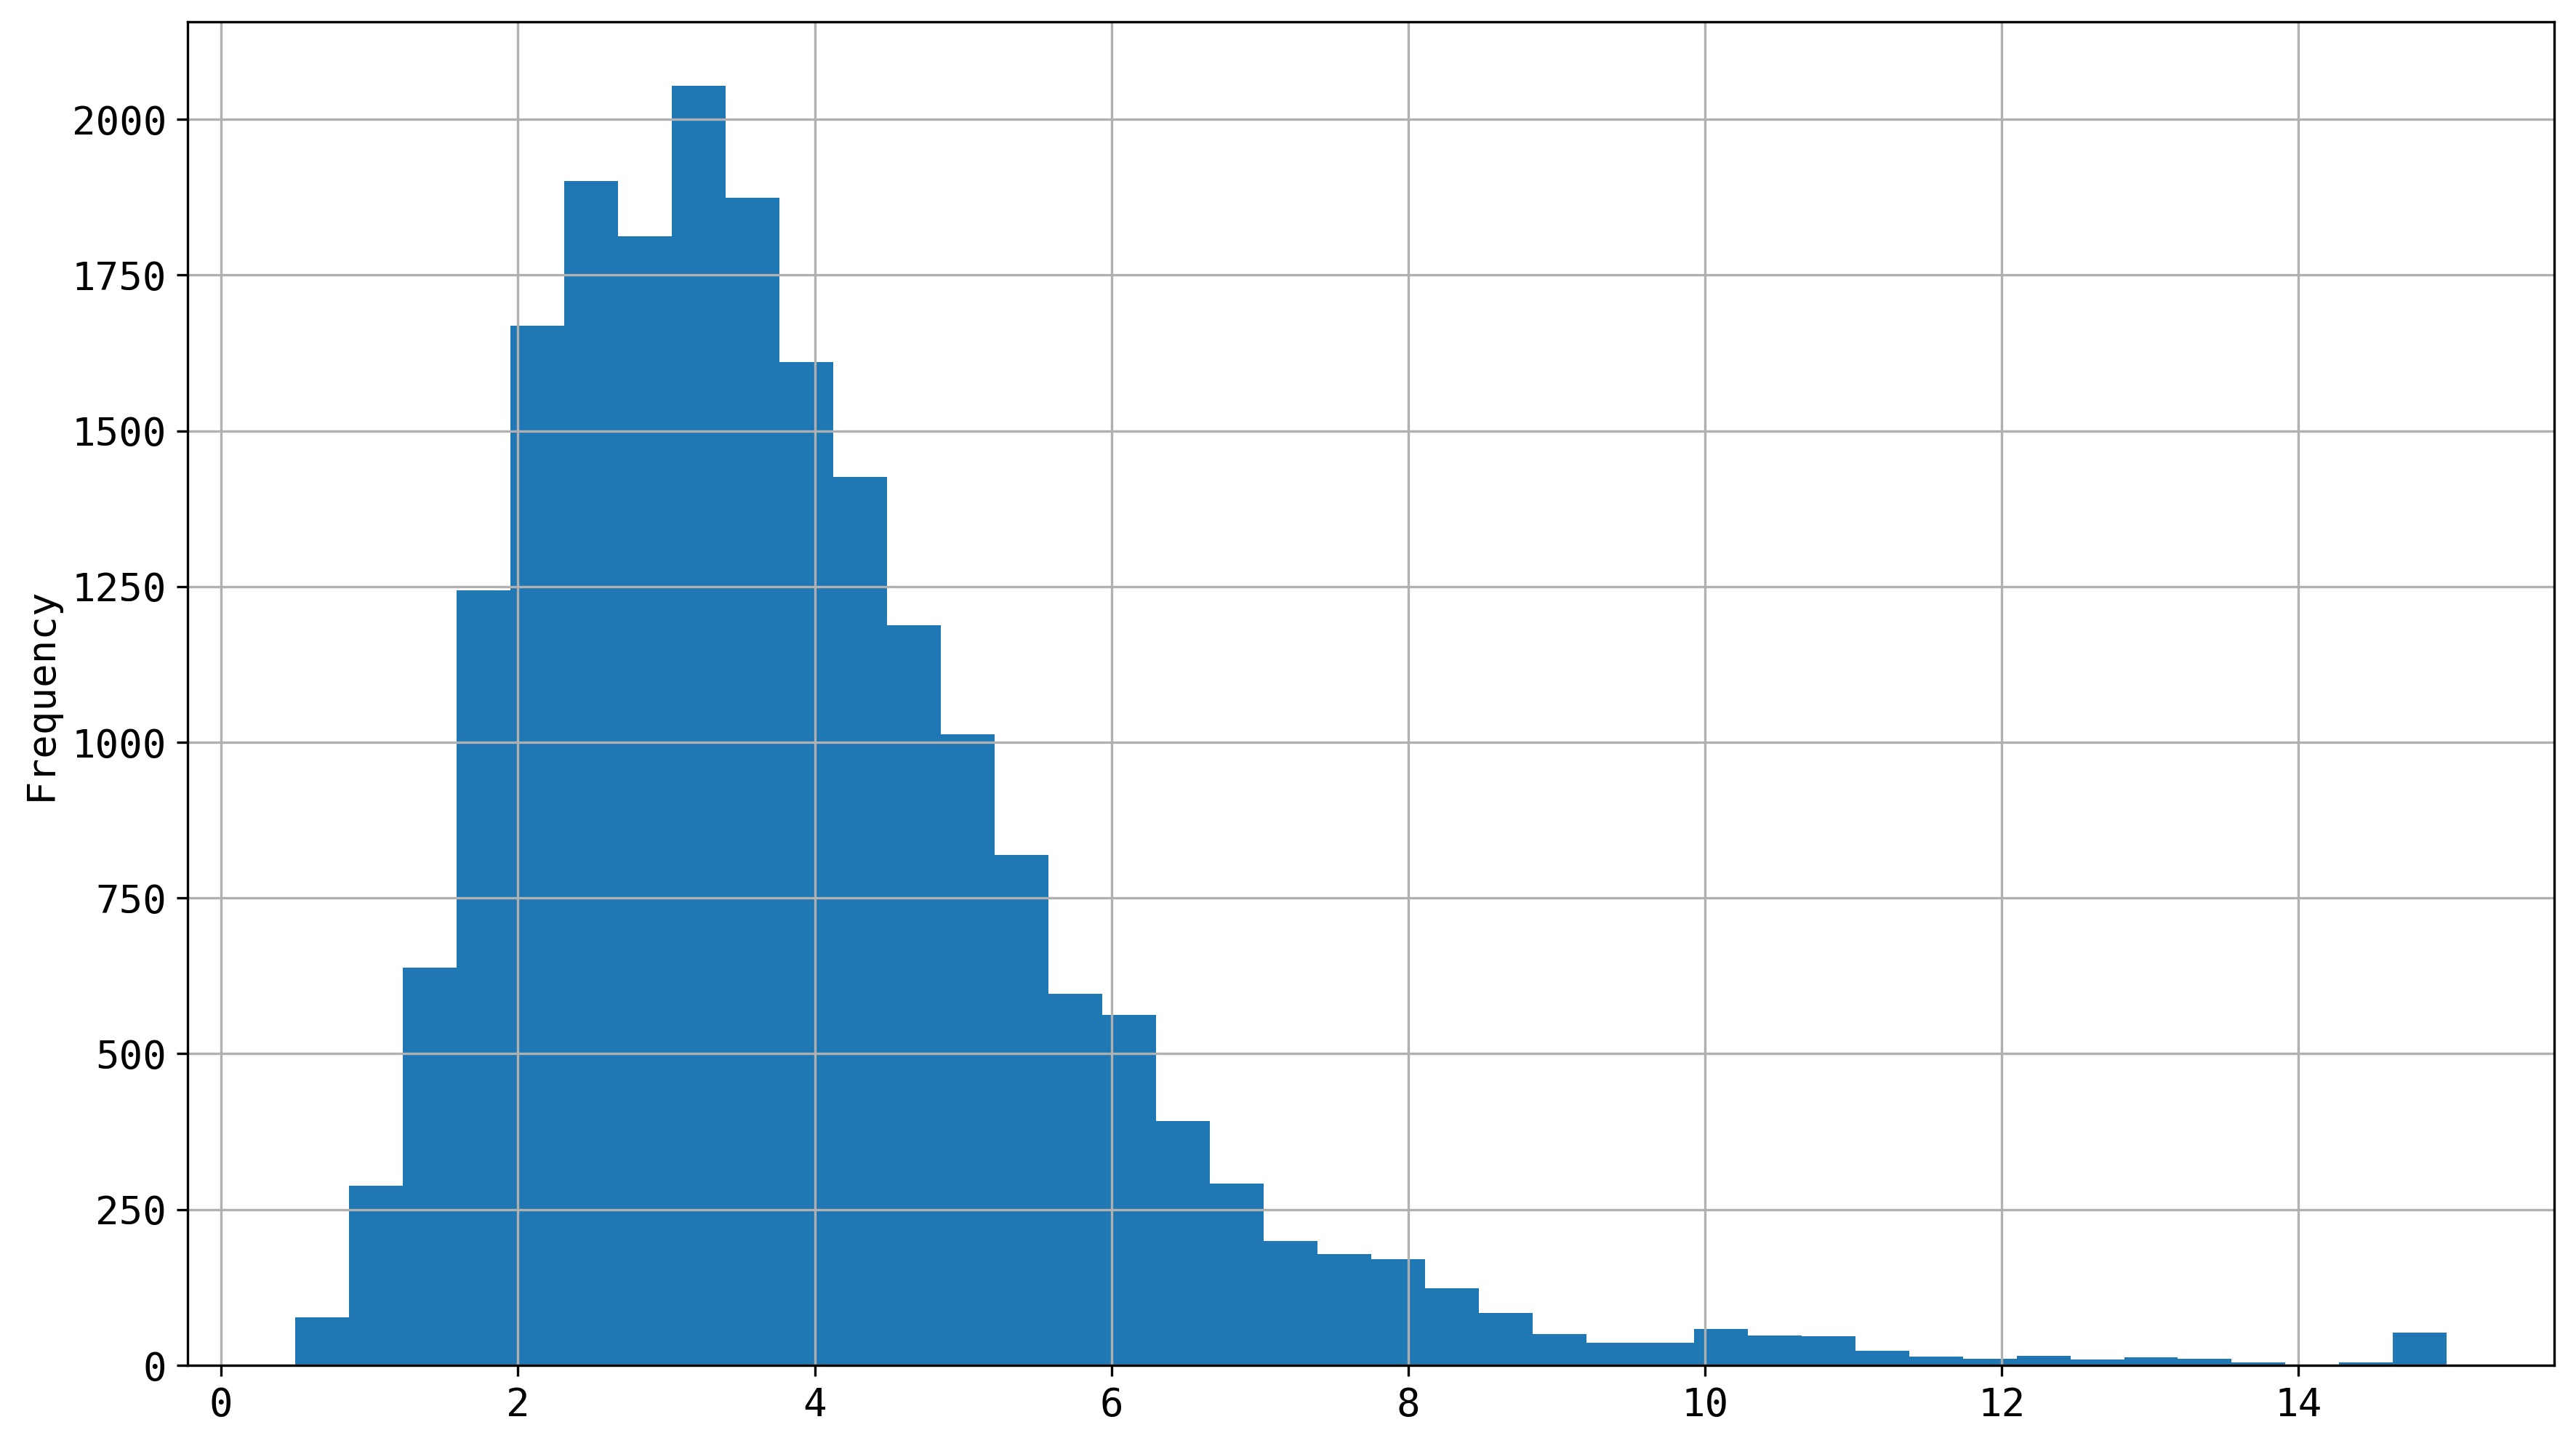

In [9]:
# visualize the median_income 

housing_num.median_income.plot.hist(bins=40, grid=True)

In [10]:
# subdivide into 5 categories

bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf]

housing_num['income_cat'] = pd.cut(housing_num["median_income"],
                                   bins=bins, labels=[1, 2, 3, 4, 5])

housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value income_cat  
0       322.0       126.0         8.3252            452600.0          5  
1      2401.0      1138.0         8.3014            358500.0          5  
2       496.0       177.0         7.2574            352100.0          5  
3       558.0       219.0         5.6431            341300.0          4  
4       565.0       259.0         3.8462            342200.0          3

In [11]:
# get the ratio of the category in the dataset

housing_num.income_cat.value_counts().sort_values(ascending=False)/ len(housing_num)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

Split the dataset into a test set representative of the dataset in order to avoid sampling bias

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# use all the dataset instead of removing the non-numnerical attributes; as was done above

bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf]

housing['income_cat'] = pd.cut(housing["median_income"],
                                   bins=bins, labels=[1, 2, 3, 4, 5])

In [14]:
# get the test dataset using this category

train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], shuffle=True)

print(len(train_set), len(test_set))

16512 4128


We want to confirm that the resulting test set is representative of the entire dataset so as to avoid sampling bias

In [15]:
# get the ratio and compare for any sample bias

test_set.income_cat.value_counts().sort_values(ascending=False) / len(test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

### **EXPLORATORY DATA ANALYSIS - EDA**

We can start to explore the training set now

In [16]:
# get a copy of the training set

housing = train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

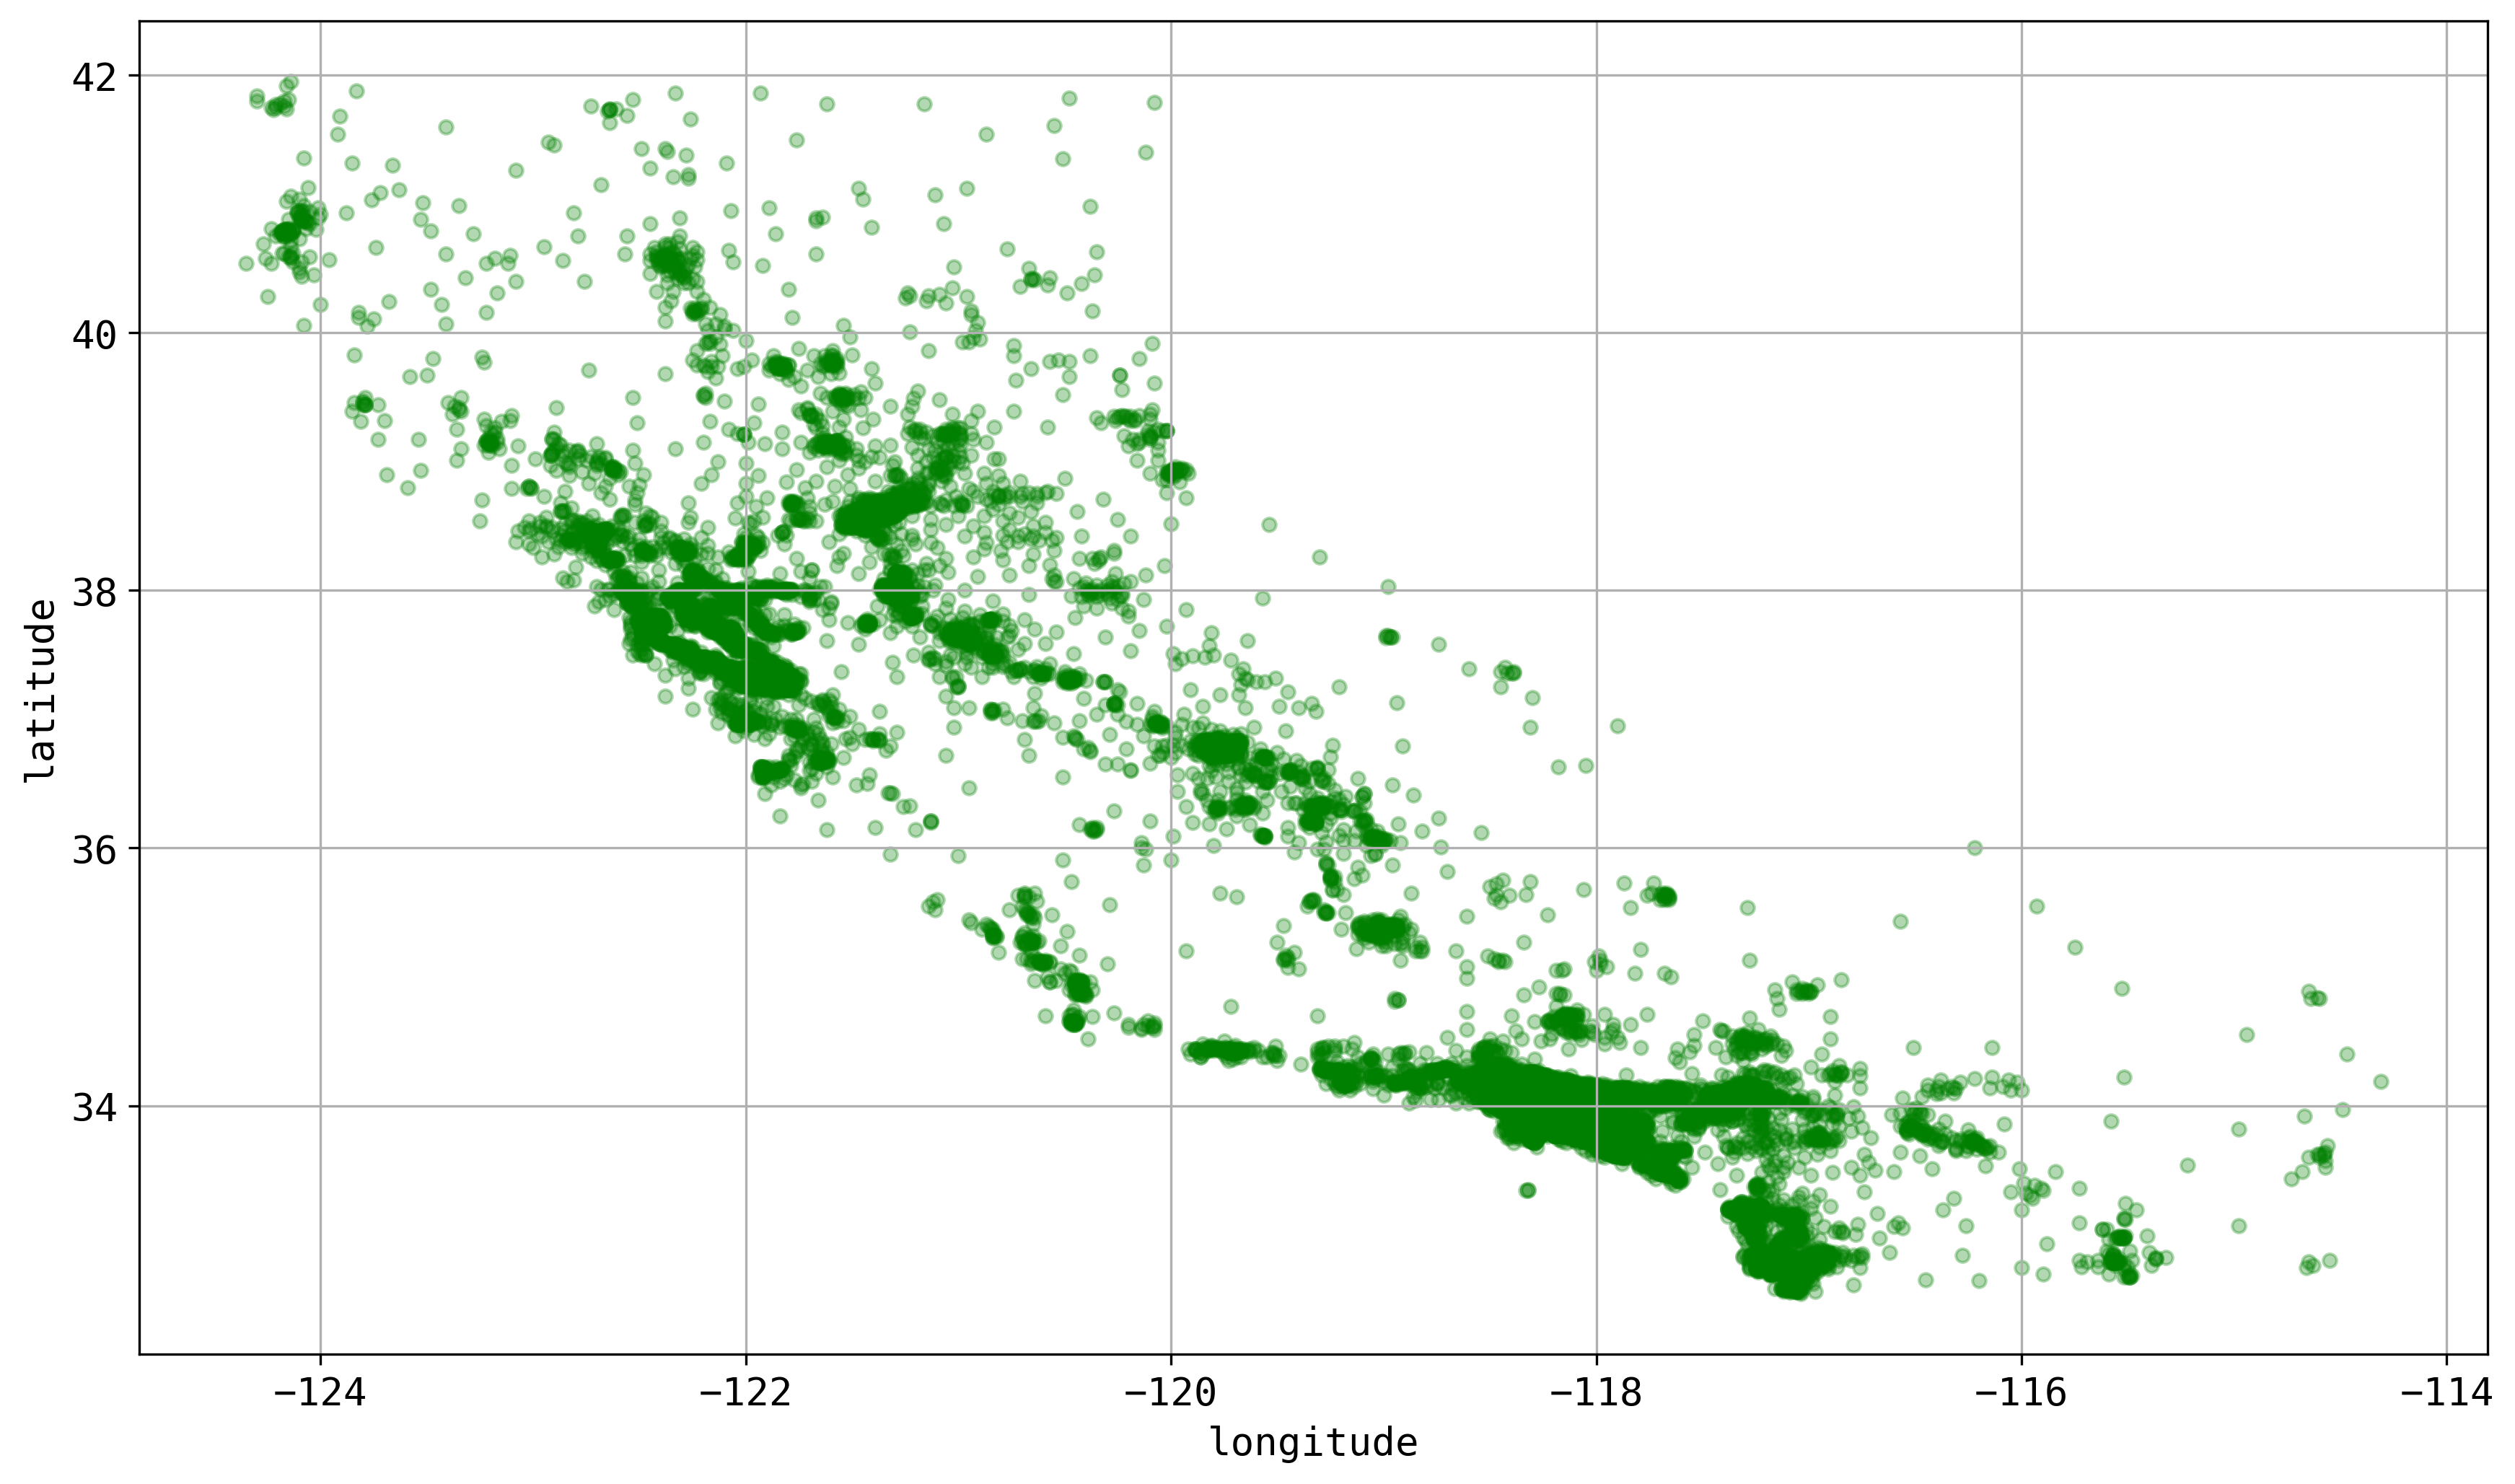

In [17]:
# visualise the geographical data

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, color='green', grid=True)

<Axes: xlabel='longitude', ylabel='latitude'>

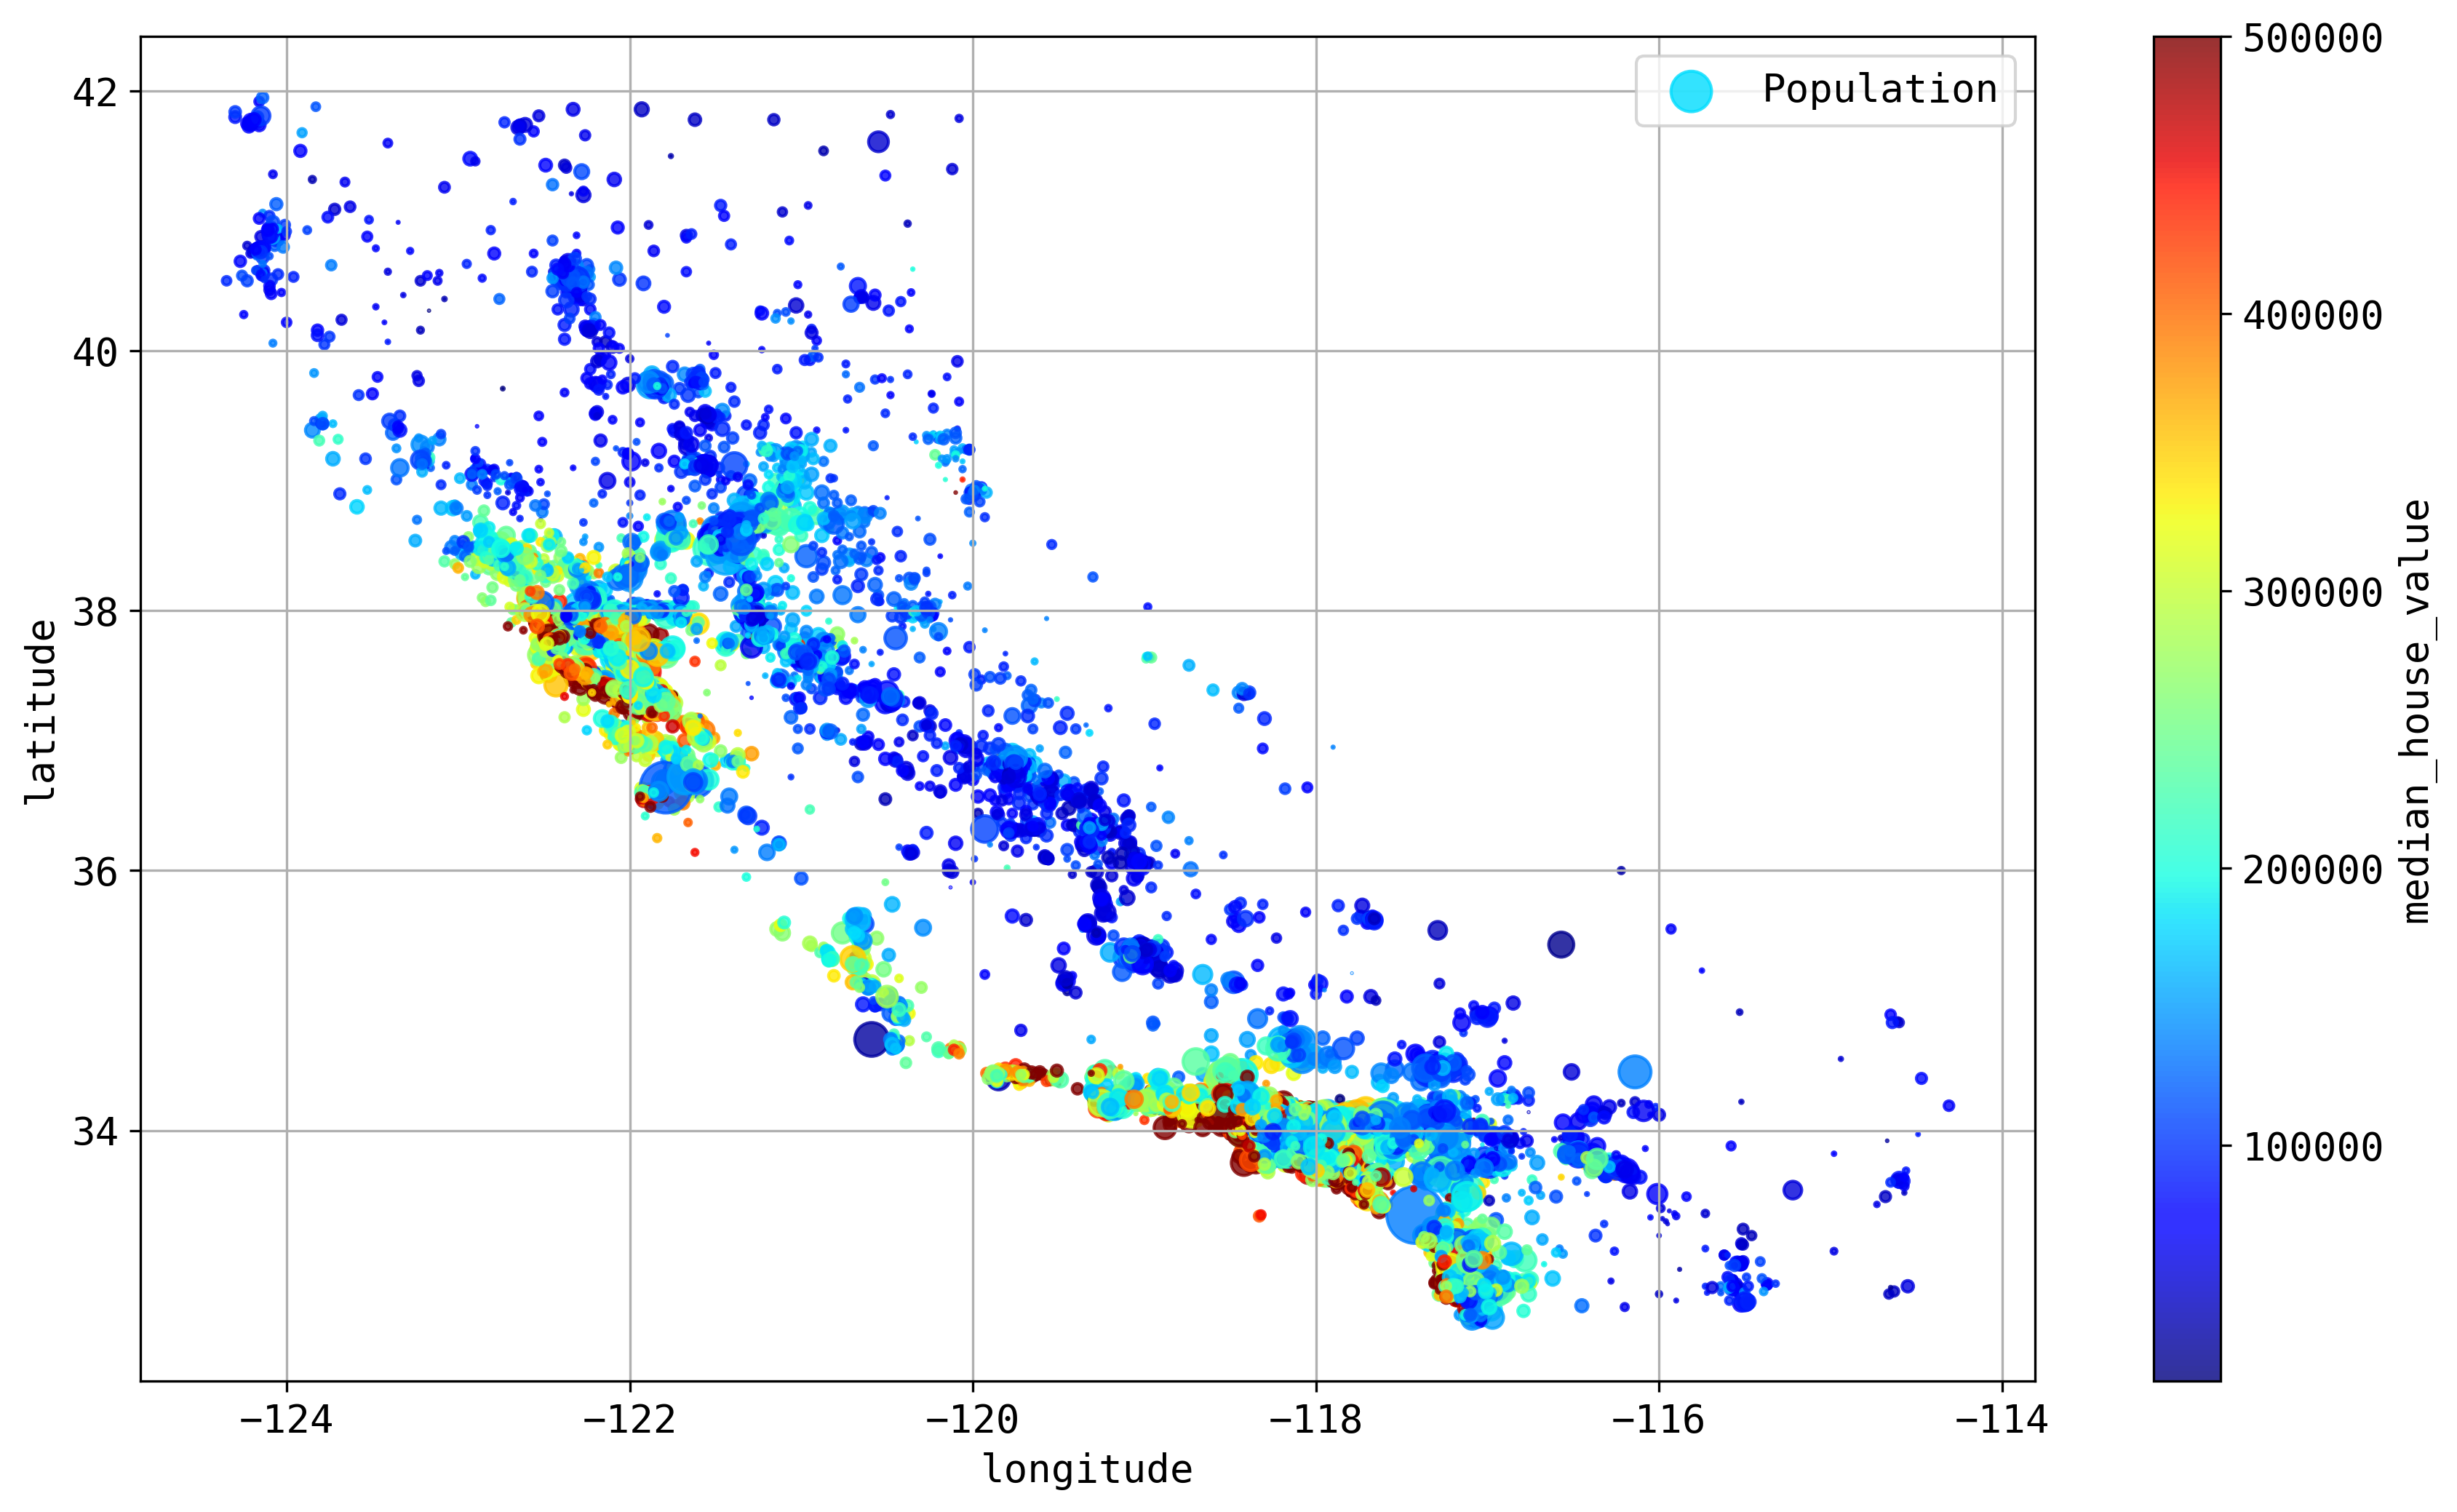

In [18]:
# add the population and households

housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    s=housing['population'] / 100,
    label='Population',
    c='median_house_value',
    colorbar=True,
    cmap='jet',
    grid=True,
    alpha=0.8, 
    legend=True, 
    sharex=False)

In [19]:
from pandas.plotting import scatter_matrix

array([[<Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housing_median_age'>,
        <Axes: xlabel='median_house_value', ylabel='housi

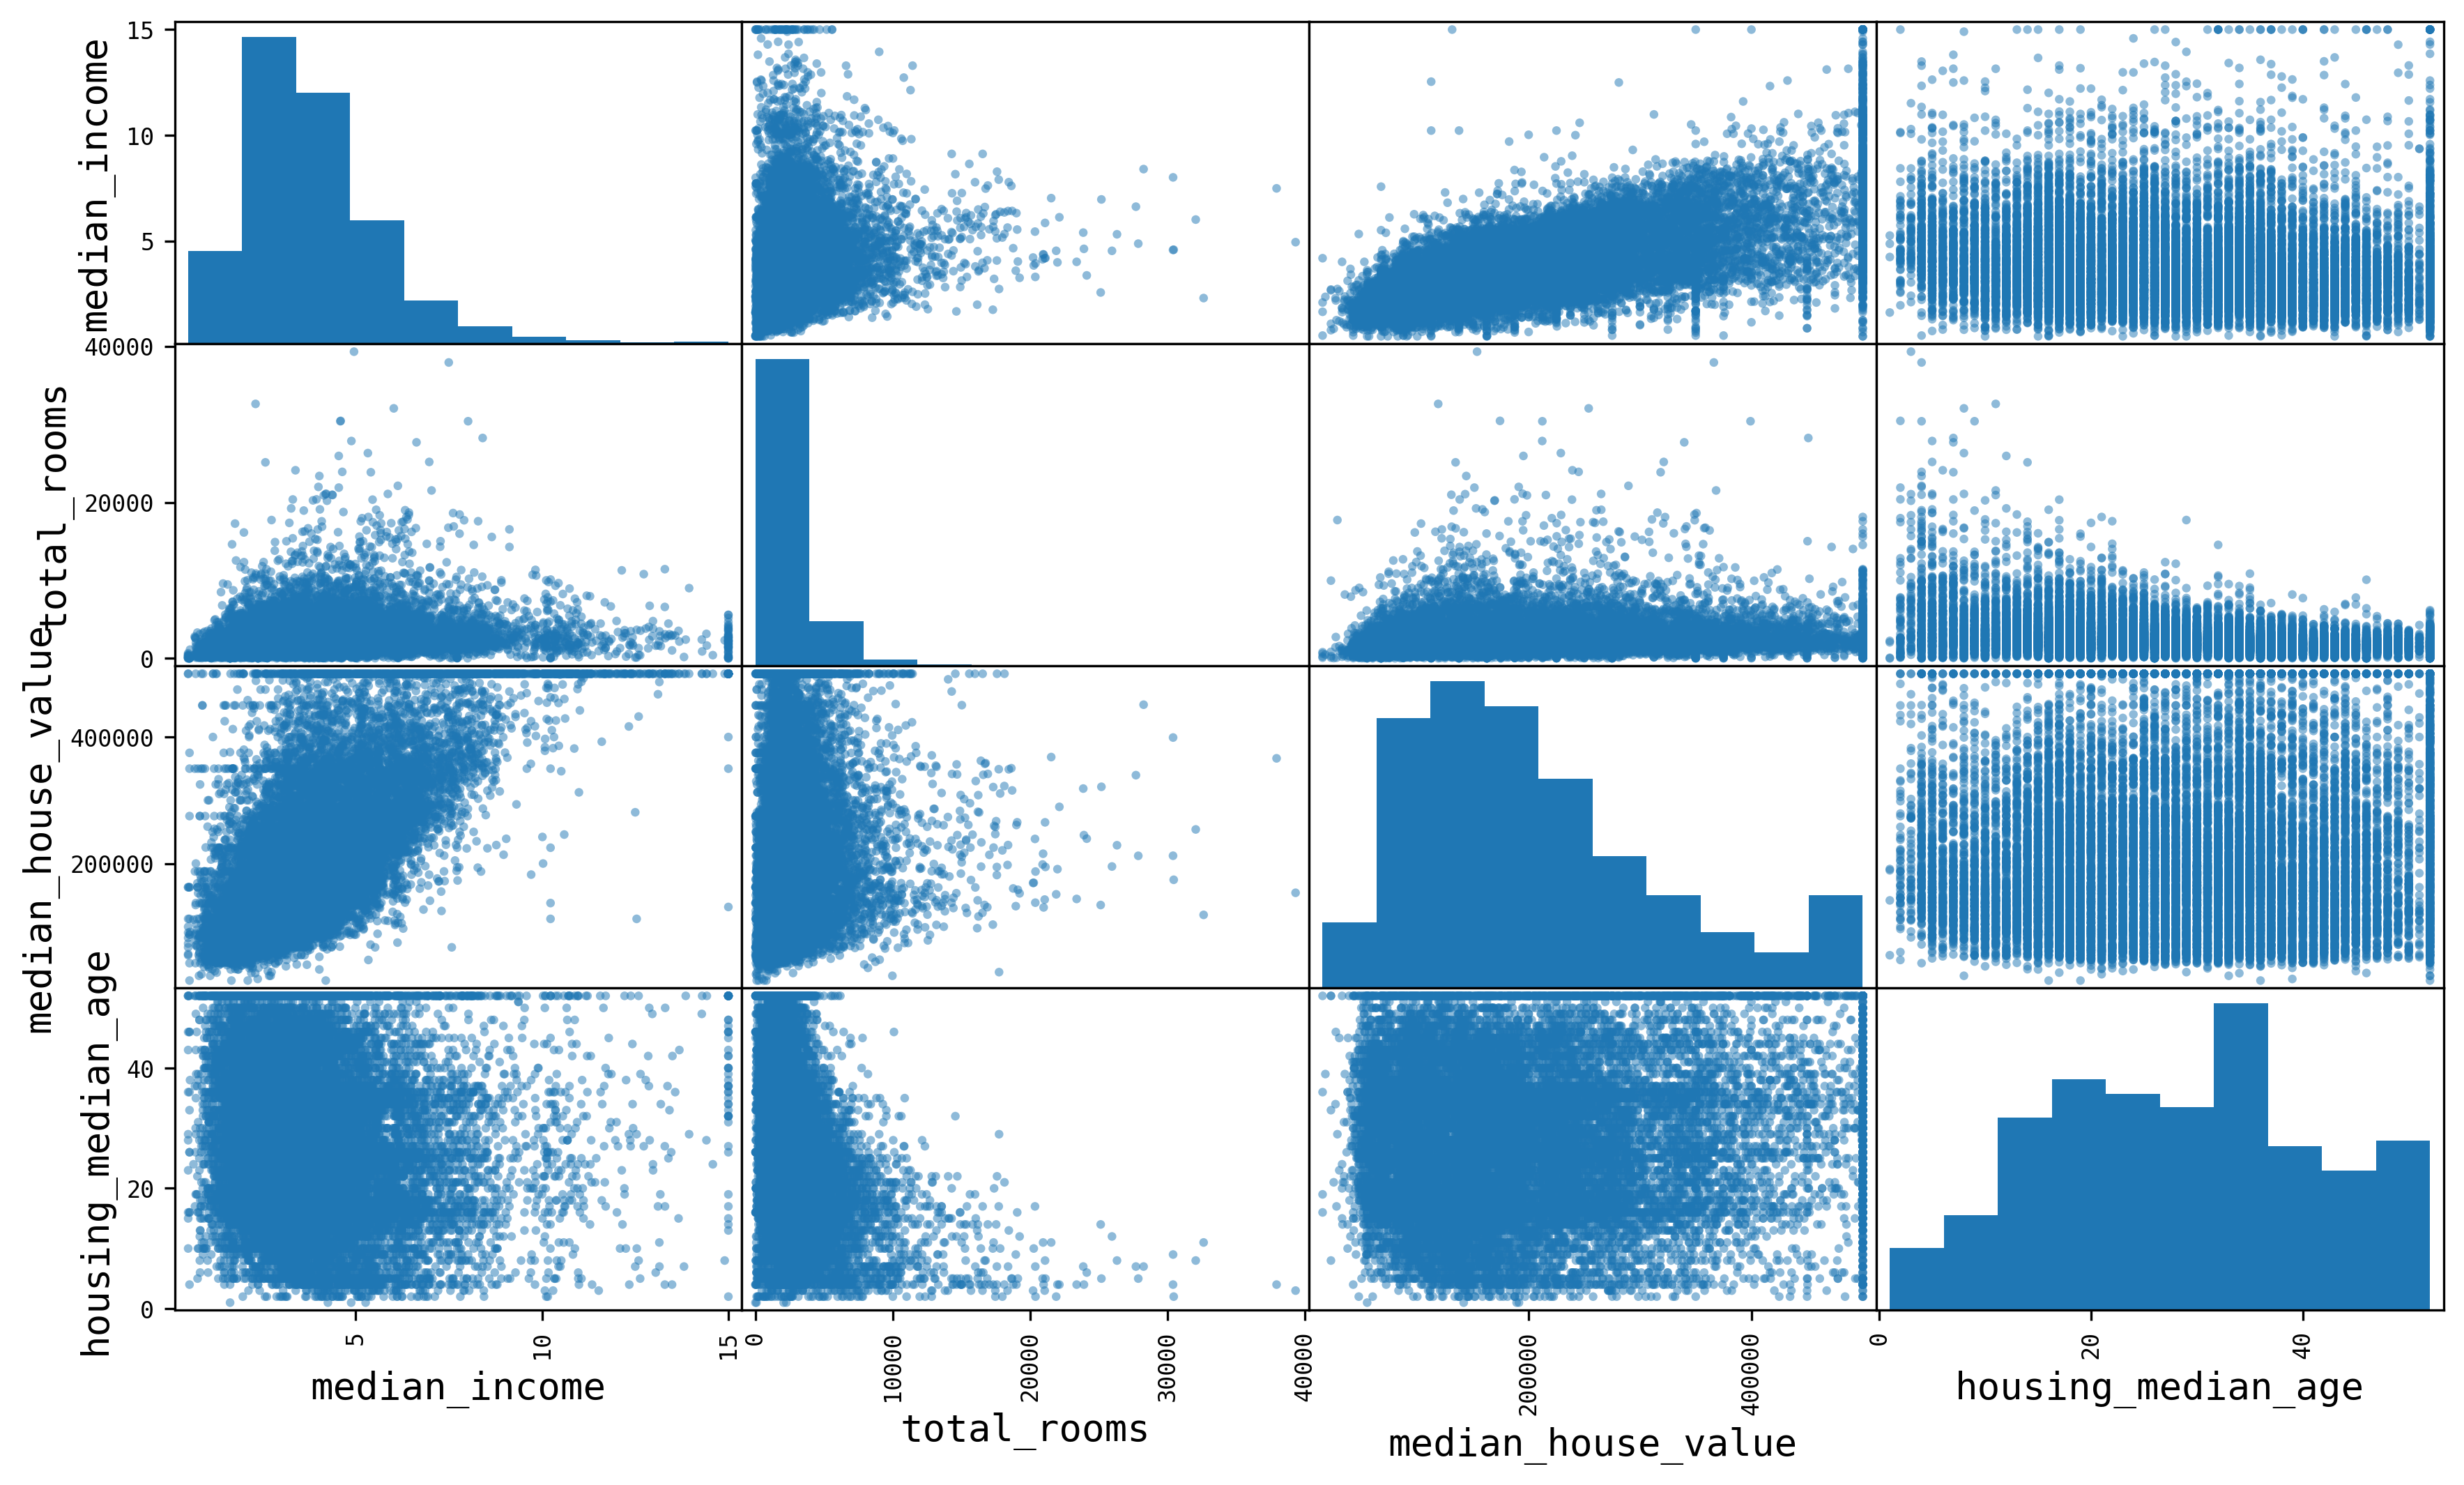

In [20]:
attr = ['median_income', 'total_rooms', 'median_house_value', 'housing_median_age']

scatter_matrix(housing_num[attr])

### **OBSERVATION - 4**

- median income remains the most correlated attributes

- there are quirkiness in the plot, and if not removed the model will learn this quirkiness
  
  - the plot indicates that there is an upper limit to *median_house_value* as *median_income* increases at $500k, ~$450k, ~$350, ~$280, ~$220k, ~$190, ~$170k, ~$140k. But this is untrue. 

> **NOTE: removing this datapoints will produce an even better model**

<Axes: xlabel='median_income', ylabel='median_house_value'>

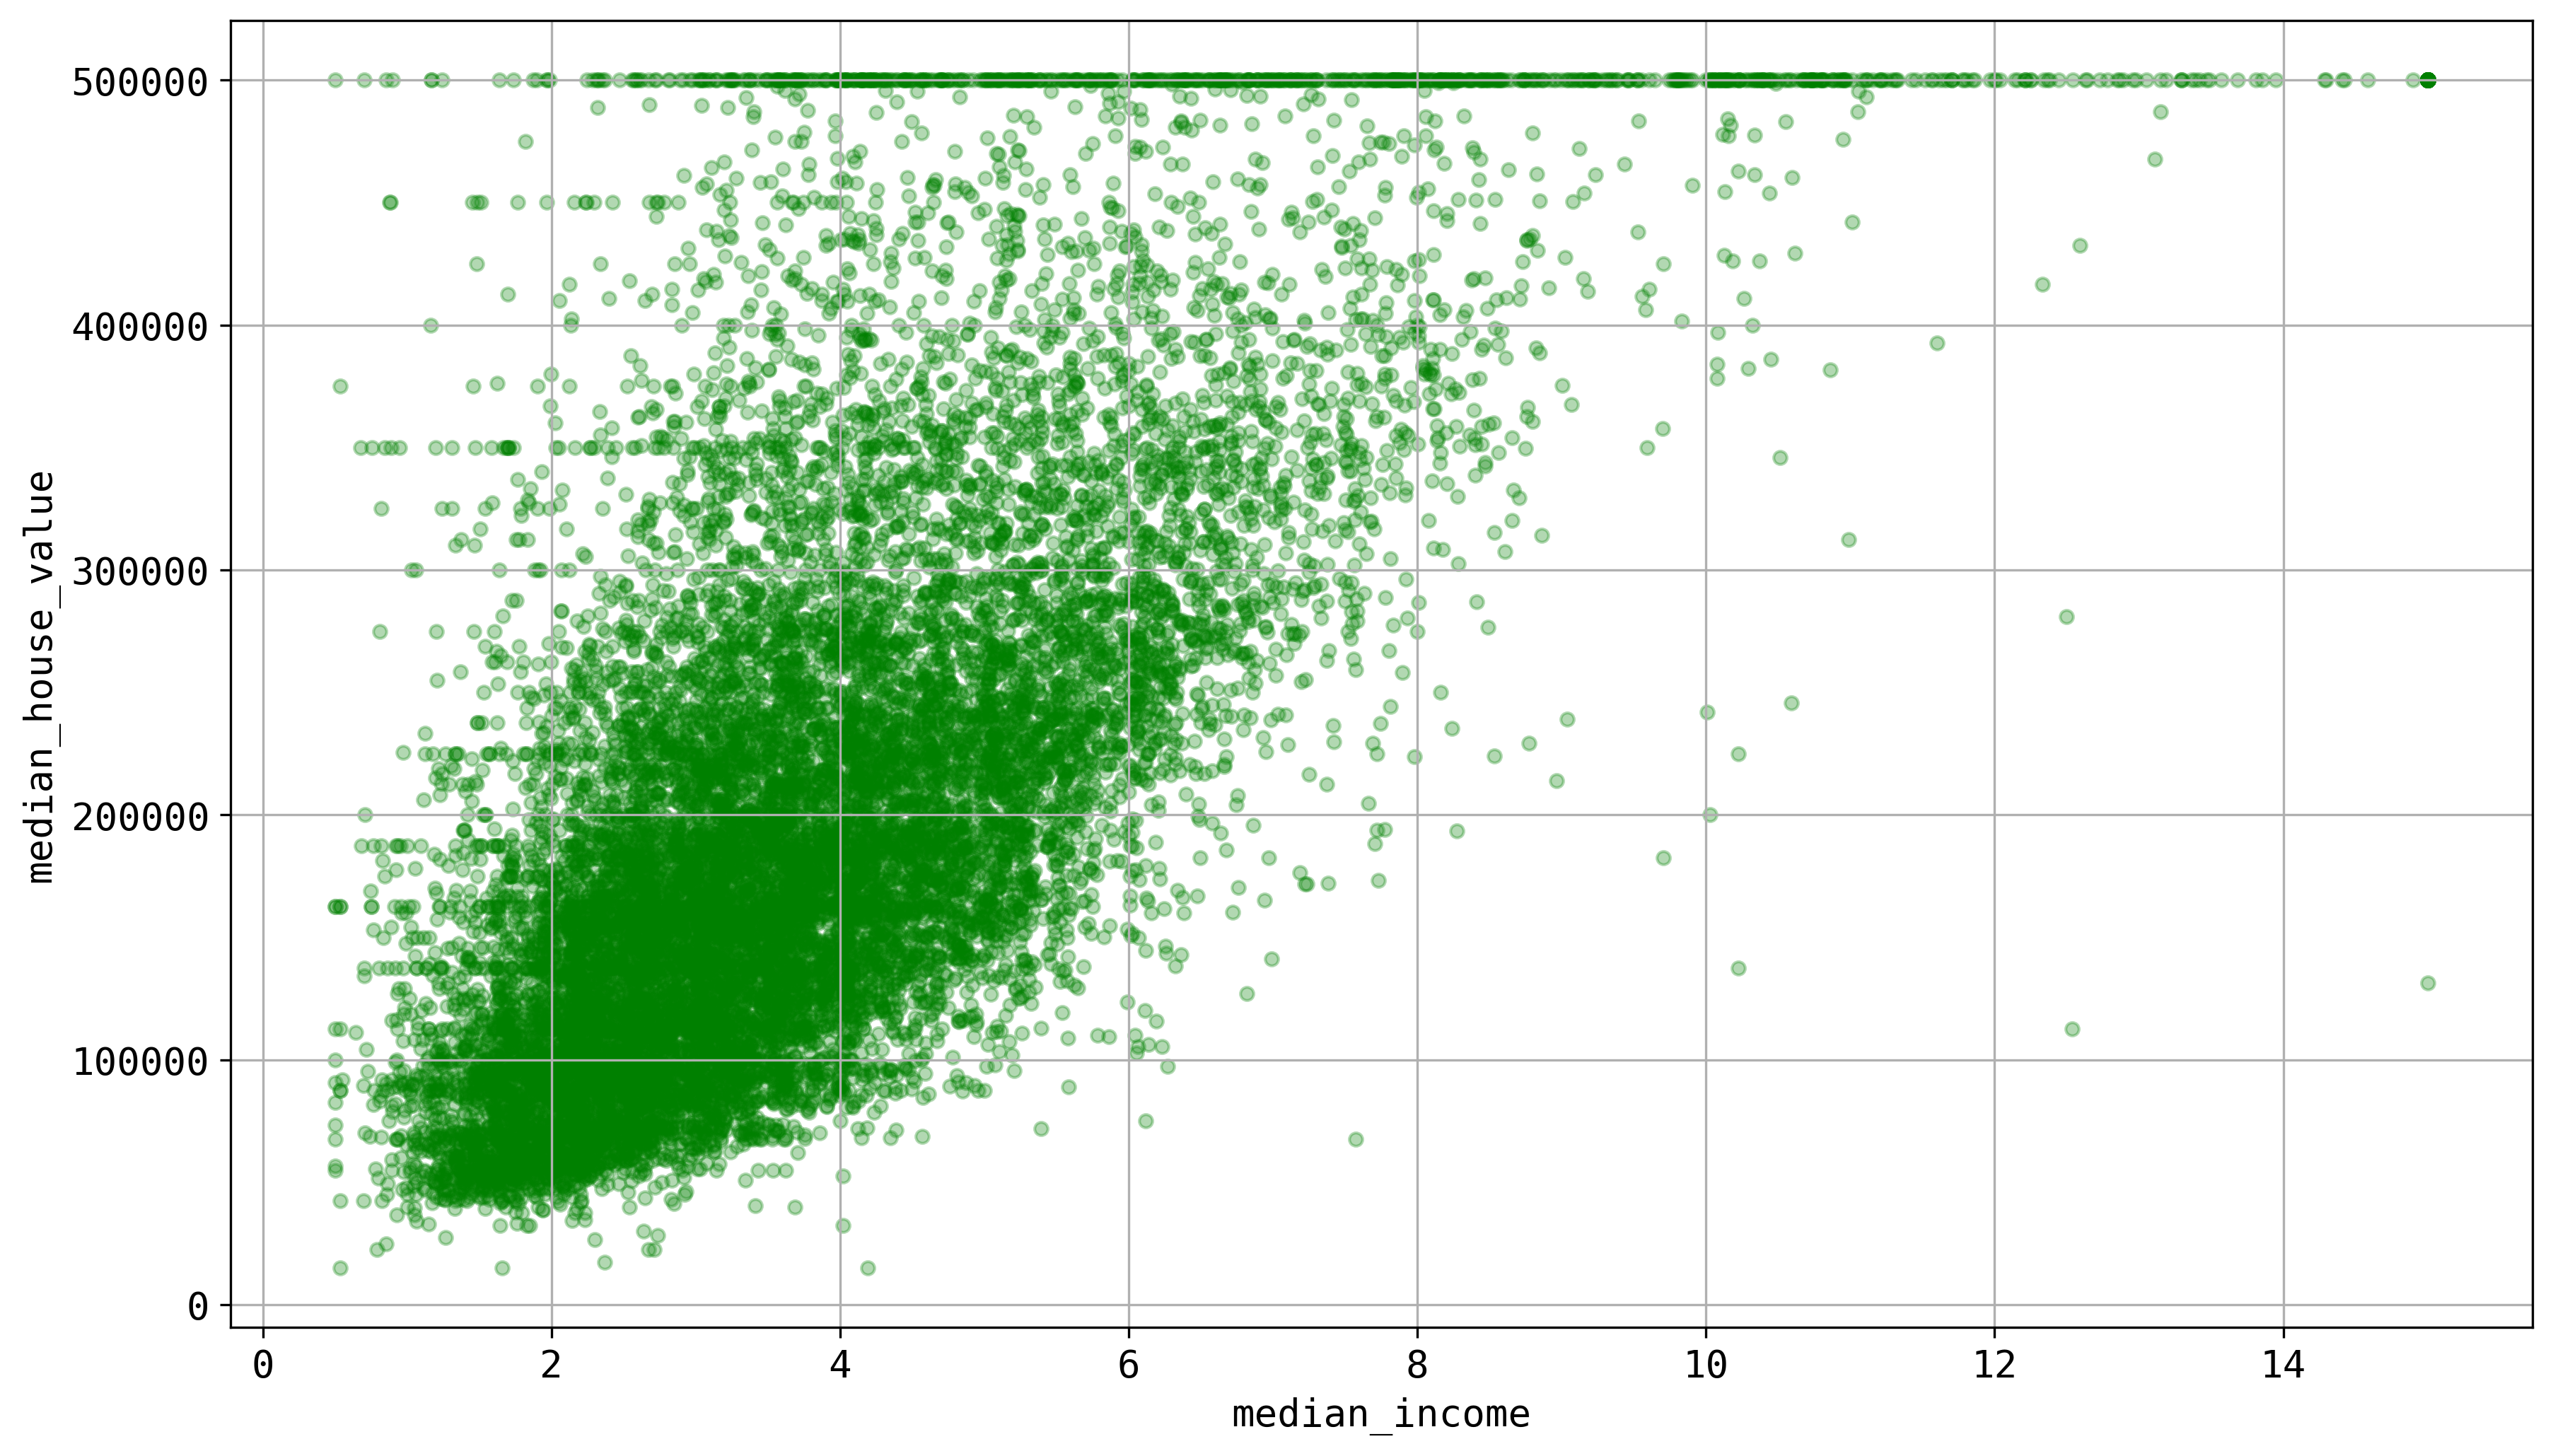

In [21]:
housing.plot(kind='scatter', y='median_house_value', x='median_income', alpha=0.3, color='green', grid=True)

### **EXPERIMENT WITH ATTRIBUTE COMBINATION**

Sometimes, combining attribute through mathematical transformation may produce a better correlation with the target values

In [22]:
# get the numerical attributes

housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'income_cat'],
      dtype='object')

In [23]:
# total room to bedroom ratio

housing_num['total_room_to_bedroom_ratio'] = housing_num['total_rooms'] / housing_num['total_bedrooms']

# total room per person
housing_num['room_to_person_ratio'] = housing_num['total_rooms'] / housing_num['households']

# house_value to bedrooms ratio

housing_num['bedrooms_to_household'] = housing_num['total_bedrooms'] / housing_num['households']

In [24]:
# compute the correlation matrix

corr_mat = housing_num.corr()

corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value             1.000000
median_income                  0.688075
income_cat                     0.643892
total_room_to_bedroom_ratio    0.383920
room_to_person_ratio           0.151948
total_rooms                    0.134153
housing_median_age             0.105623
households                     0.065843
total_bedrooms                 0.049686
population                    -0.024650
longitude                     -0.045967
bedrooms_to_household         -0.046739
latitude                      -0.144160
Name: median_house_value, dtype: float64

#### **OBSERVATION - 5**

The combination yielded a better linear correlation than the stand alone attributes.For example, the ***total_room_to_bedroom_ratio*** yielded a better correlation than ***total_rooms*** or ***total_bedrooms***

## **PREPARING DATA FOR MACHINE LEARNING**

- get a copy of the data

- drop the target value

- Clean the data

- Standardize or normalize the dataset

- perform necessary transformation; by creating a transformation pipeline is necessary

In [25]:
# get a copy of the training set and drop the target attribute

# the drop method returns a copy of the dataframe/series
housing = train_set.drop(["median_house_value", "income_cat"], axis=1)

# get the label data
housing_labels = train_set["median_house_value"].copy()

In [26]:
# clean the data and transform missing values

housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 5326 to 11986
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16355 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [27]:
# replace the  missing values in total bedrooms with the median value

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [28]:
housing_num = housing.select_dtypes(include=[np.number])

**FIT** method will learn the value that will be used in each column; so that when the **TRANSFORM** is invoked, the ***learned values*** can be used in the dataset, wherever necessary.

In [29]:
# fit the training set to the estimator

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
X = imputer.transform(housing_num)

### **NOTE**

The **TRANSFORM** method, by default, will return a **Numpy** array instead of a **DataFrame**.

This can be modified by setting the returned transformed values to a dataframe, or explicitly converting the result to a DataFrame, as shown below. 

In [31]:
X

array([[-1.1845e+02,  3.4050e+01,  2.8000e+01, ...,  9.3600e+02,
         4.0600e+02,  2.1875e+00],
       [-1.1817e+02,  3.4090e+01,  4.5000e+01, ...,  1.0690e+03,
         2.8400e+02,  3.3977e+00],
       [-1.1710e+02,  3.2830e+01,  1.6000e+01, ...,  1.8200e+03,
         6.9900e+02,  4.3783e+00],
       ...,
       [-1.1762e+02,  3.3430e+01,  2.7000e+01, ...,  2.3210e+03,
         8.7300e+02,  3.3155e+00],
       [-1.2229e+02,  3.7840e+01,  3.5000e+01, ...,  1.0170e+03,
         4.1400e+02,  2.2106e+00],
       [-1.1751e+02,  3.4020e+01,  2.4000e+01, ...,  3.9960e+03,
         1.7650e+03,  2.1764e+00]])

In [32]:
# convert the trained set X to a Dataframe

housing_trained = pd.DataFrame(X, columns=imputer.get_feature_names_out(), index=housing_num.index)

housing_trained.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5326     -118.45     34.05                28.0        801.0           399.0   
4455     -118.17     34.09                45.0       1327.0           271.0   
14680    -117.10     32.83                16.0       4214.0           744.0   
2142     -119.75     36.78                33.0       1145.0           197.0   
10272    -117.87     33.87                16.0       1332.0           368.0   

       population  households  median_income  
5326        936.0       406.0         2.1875  
4455       1069.0       284.0         3.3977  
14680      1820.0       699.0         4.3783  
2142        508.0       198.0         2.3333  
10272      1534.0       295.0         3.0227

## **Data Transformation Pipeline**

- Perform imputation on the numerical attributes using the median

- Perform imputation on the categorical attributes using the most frequent data point

- Standardize the numerical features so that they have a mean of 0 and standard deviation of 1.

- Encode the categorical feature `ocean_proximity` using the **ONE-HOT** encoding scheme

In [33]:
# create the transformation Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

In [34]:
# this pipeline would behave like a transformer since...
# the last estimator is a transformer


numerical_pipeline = Pipeline(
    steps=[
        ("simple-impute", SimpleImputer(strategy="median")),
        ("scaling", StandardScaler())])

# this pipeline would also behave like a transformer since...
# the last estimator is a transformer
categorical_pipeline = Pipeline(
    steps=[
        ('cat-simple-impute', SimpleImputer(strategy="most_frequent")),
        ("1hot-encoding", OneHotEncoder(handle_unknown="ignore"))])

In [35]:
# create the column transformer to handle the attribute in one step

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

In [36]:
# create a transformer that will handle both classes of attributes

preprocessing = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, make_column_selector(dtype_include=np.number)),
        ("cat", categorical_pipeline, make_column_selector(dtype_include=object))])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simple-impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x73ac3b8e4260>),
                                ('cat',
                                 Pipeline(steps=[('cat-simple-impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('1hot-encoding',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x73ac403a5b20>)])

In [37]:
housing = train_set.copy().drop(["income_cat", "median_house_value"], axis=1)

housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5326     -118.45     34.05                28.0        801.0           399.0   
4455     -118.17     34.09                45.0       1327.0           271.0   
14680    -117.10     32.83                16.0       4214.0           744.0   
2142     -119.75     36.78                33.0       1145.0           197.0   
10272    -117.87     33.87                16.0       1332.0           368.0   
...          ...       ...                 ...          ...             ...   
15386    -117.03     33.32                14.0       1088.0           209.0   
17035    -122.26     37.50                52.0        878.0           186.0   
10432    -117.62     33.43                27.0       3858.0          1062.0   
506      -122.29     37.84                35.0       1872.0           419.0   
11986    -117.51     34.02                24.0       7779.0          1835.0   

       population  households  median_income ocean_proximity  
5326        936.0       406.0         2.1875       <1H OCEAN  
4455       1069.0       284.0         3.3977       <1H OCEAN  
14680      1820.0       699.0         4.3783       <1H OCEAN  
2142        508.0       198.0         2.3333          INLAND  
10272      1534.0       295.0         3.0227       <1H OCEAN  
...           ...         ...            ...             ...  
15386       601.0       193.0         3.8438       <1H OCEAN  
17035       393.0       186.0         3.7045      NEAR OCEAN  
10432      2321.0       873.0         3.3155      NEAR OCEAN  
506        1017.0       414.0         2.2106        NEAR BAY  
11986      3996.0      1765.0         2.1764          INLAND  

[16512 rows x 9 columns]

In [38]:
# apply the transformation on housing dataset

housing_prepared = preprocessing.fit_transform(housing)

df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)

df_housing_prepared

num__longitude  num__latitude  num__housing_median_age  \
5326         0.555598      -0.737756                -0.051930   
4455         0.695092      -0.719055                 1.298278   
14680        1.228155      -1.308125                -1.005018   
2142        -0.092048       0.538562                 0.345190   
10272        0.844549      -0.821909                -1.005018   
...               ...            ...                      ...   
15386        1.263028      -1.079042                -1.163866   
17035       -1.342505       0.875173                 1.854246   
10432        0.969096      -1.027615                -0.131354   
506         -1.357451       1.034129                 0.504038   
11986        1.023897      -0.751781                -0.369626   

       num__total_rooms  num__total_bedrooms  num__population  \
5326          -0.830130            -0.328658        -0.429439   
4455          -0.593674            -0.629801        -0.314659   
14680          0.704139             0.483016         0.333462   
2142          -0.675489            -0.803899        -0.798807   
10272         -0.591426            -0.401591         0.086641   
...                 ...                  ...              ...   
15386         -0.701113            -0.775667        -0.718547   
17035         -0.795515            -0.829779        -0.898053   
10432          0.544104             1.231168         0.765830   
506           -0.348676            -0.281605        -0.359535   
11986          2.306737             3.049788         2.211371   

       num__households  num__median_income  cat__ocean_proximity_<1H OCEAN  \
5326         -0.246776           -0.884762                             1.0   
4455         -0.561253           -0.250102                             1.0   
14680         0.508486            0.264150                             1.0   
2142         -0.782934           -0.808301                             0.0   
10272        -0.532899           -0.446762                             1.0   
...                ...                 ...                             ...   
15386        -0.795823           -0.016156                             1.0   
17035        -0.813866           -0.089208                             0.0   
10432         0.957003           -0.293210                             0.0   
506          -0.226154           -0.872648                             0.0   
11986         3.256298           -0.890583                             0.0   

       cat__ocean_proximity_INLAND  cat__ocean_proximity_ISLAND  \
5326                           0.0                          0.0   
4455                           0.0                          0.0   
14680                          0.0                          0.0   
2142                           1.0                          0.0   
10272                          0.0                          0.0   
...                            ...                          ...   
15386                          0.0                          0.0   
17035                          0.0                          0.0   
10432                          0.0                          0.0   
506                            0.0                          0.0   
11986                          1.0                          0.0   

       cat__ocean_proximity_NEAR BAY  cat__ocean_proximity_NEAR OCEAN  
5326                             0.0                              0.0  
4455                             0.0                              0.0  
14680                            0.0                              0.0  
2142                             0.0                              0.0  
10272                            0.0                              0.0  
...                              ...                              ...  
15386                            0.0                              0.0  
17035                            0.0                              1.0  
10432                            0.0                   

## **CLUSTER SIMILARITY SEARCH**

We would like to see if there are clusters within the dataset, and then use a radial basis function to determine how (similar) close or far (a distance measurement) each datapoints are from each cluster centers. 

The distance measurement is that of the cluster centers from the `longitude` and `latitude`.

**PROCEDURES**

1. **FIT** a *KMeans algorithm* to the dataset to determine the `cluster centers`.

2. **TRANSFORM** the dataset using a *gaussian radial basis function*, where the *fixed point would be the cluster centers*, and the `decay rate; gamma = 1.0`


Since this is not a stateless transformation (learned parameters; cluster centers are needed), then we can instead implement a custom transformer

In [39]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.base import check_array, check_is_fitted

In [40]:
class ClusterSimilaritySearch(BaseEstimator, TransformerMixin):
    """
    This performs a similarity meassurement, by using a clustering algorithm to determine the cluster centers, and then a scaled distance measurement, of the distance of each datapoints from the fixed cluster centers is computed through the gaussian radial basis function.

    The parameters to an instance is;

    n_clusters: int| determines the number of clustering centers
    gamma: float| determines the decay rate
    random_state: int| determines the reproducibility of the clustering algorithm
    """

    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        """Instantiates using the decay rate; gamma, number of clusters; n_clusters and KMeans random state for reproducibility; random_state"""

        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        """fit KMeans algorithm to the X, and save the cluster centers, as the learned parameters"""

        # check that it contains finite float only
        # check_array(X)

        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)

        if type(sample_weight) == "numpy.ndarray":
            sample_weight = sample_weight.to_numpy()

        self.kmeans_.fit(X, sample_weight=sample_weight)

        # self.feature_names_in_ = X.shape[1]
        return self     # always return self

    def transform(self, X):
        """Transform the data using the radial basis kernel function, where the fixed point(s) are the cluster center(s)"""

        # check X contains finite floats
        # check_array(X)

        # check that X is fitted
        # check_is_fitted(X)

        cluster_center_Y = self.kmeans_.cluster_centers_
        
        return rbf_kernel(X, cluster_center_Y, gamma=self.gamma)

    def get_feature_names_out(self, names=None):

        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]        

### **TRANSFORMATION PIPELINE**

Here we define all the transformation on our dataset at once

In [41]:
from sklearn.pipeline import FunctionTransformer


def column_ratio(X):
    """takes a 2D-numpy array, with 2 columns, and divide the first columns using the second column"""
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    """This function takes two input parameters, used by the get_feature_names_out function. Where the first parameter must be the function transformer itself, and the second parameter is the feature names passed into the transformer.

    In this case however, they are not used, they are there for the sake of satisfying the API
    """
    return ["ratio"]

def ratio_pipeline():
    """construct a new feature whose values are from the ratio of two specified features"""
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_similarity = ClusterSimilaritySearch(n_clusters=10, gamma=1.0, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

In [42]:
preprocessing = ColumnTransformer(
    transformers=[
        ('bedrooms', ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", cluster_similarity, ["latitude", "longitude"]),
        ("cat", categorical_pipeline, make_column_selector(dtype_include=object))
        ],
    # the remainder is "median_house_age"
    remainder=default_num_pipeline)

In [43]:
housing_prepared = preprocessing.fit_transform(housing)

In [44]:
df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)

df_housing_prepared

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
5326          4.275307               -1.464375                -0.071554   
4455         -0.145393               -0.316853                 0.065887   
14680        -0.561516                0.259571                -0.043447   
2142         -0.629230                0.155096                -0.047034   
10272         0.938415               -0.383707                 0.201184   
...                ...                     ...                      ...   
15386        -0.327758                0.093239                 0.004632   
17035        -0.030703               -0.296494                -0.089694   
10432         0.923312               -0.424518                -0.038272   
506           0.149485               -0.380951                -0.057317   
11986         0.330982               -0.429567                -0.075455   

       log__total_bedrooms  log__total_rooms  log__population  \
5326             -0.086538         -1.251465        -0.250052   
4455             -0.616175         -0.581973        -0.070397   
14680             0.766536          0.950454         0.649115   
2142             -1.052810         -0.777611        -1.076415   
10272            -0.197271         -0.576985         0.417949   
...                    ...               ...              ...   
15386            -0.971852         -0.845332        -0.849095   
17035            -1.131476         -1.129738        -1.423481   
10432             1.253764          0.833398         0.977913   
506              -0.019575         -0.125641        -0.137825   
11986             2.002527          1.763442         1.712546   

       log__households  log__median_income  geo__Cluster 0 similarity  \
5326          0.032401           -0.982054               5.328531e-01   
4455         -0.454259           -0.047010               7.536140e-01   
14680         0.772236            0.491418               2.241166e-01   
2142         -0.945452           -0.845039               3.532225e-06   
10272        -0.402512           -0.295345               9.584752e-01   
...                ...                 ...                        ...   
15386        -0.980281            0.214946               4.680916e-01   
17035        -1.030589            0.136562               1.802093e-15   
10432         1.074932           -0.099014               7.902521e-01   
506           0.058972           -0.959748               1.062066e-16   
11986         2.033562           -0.992856               9.640238e-01   

       geo__Cluster 1 similarity  ...  geo__Cluster 6 similarity  \
5326                1.940756e-12  ...               1.993013e-20   
4455                2.968439e-13  ...               3.561488e-21   
14680               4.443682e-22  ...               3.497477e-32   
2142                1.262196e-03  ...               6.871525e-07   
10272               4.840853e-15  ...               2.411144e-23   
...                          ...  ...                        ...   
15386               1.955061e-20  ...               1.080085e-29   
17035               9.659078e-01  ...               9.525028e-03   
10432               1.540060e-17  ...               1.327929e-26   
506                 9.579960e-01  ...               3.655514e-02   
11986               5.845804e-16  ...               5.264243e-24   

       geo__Cluster 7 similarity  geo__Cluster 8 similarity  \
5326                2.904942e-02                   0.026613   
4455                5.812807e-02                   0.009878   
14680               9.484173e-01                   0.000001   
2142                1.527616e-10                   0.018271   
10272               1.764944e-01                   0.001852   
...                          ...                        ...   
15386               8.695453e-01                   0.000005   
17035               4.494146e-22                   0.000011   
10432               4.888634e-01                   0.000194   
5

In [45]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

<Axes: ylabel='Density'>

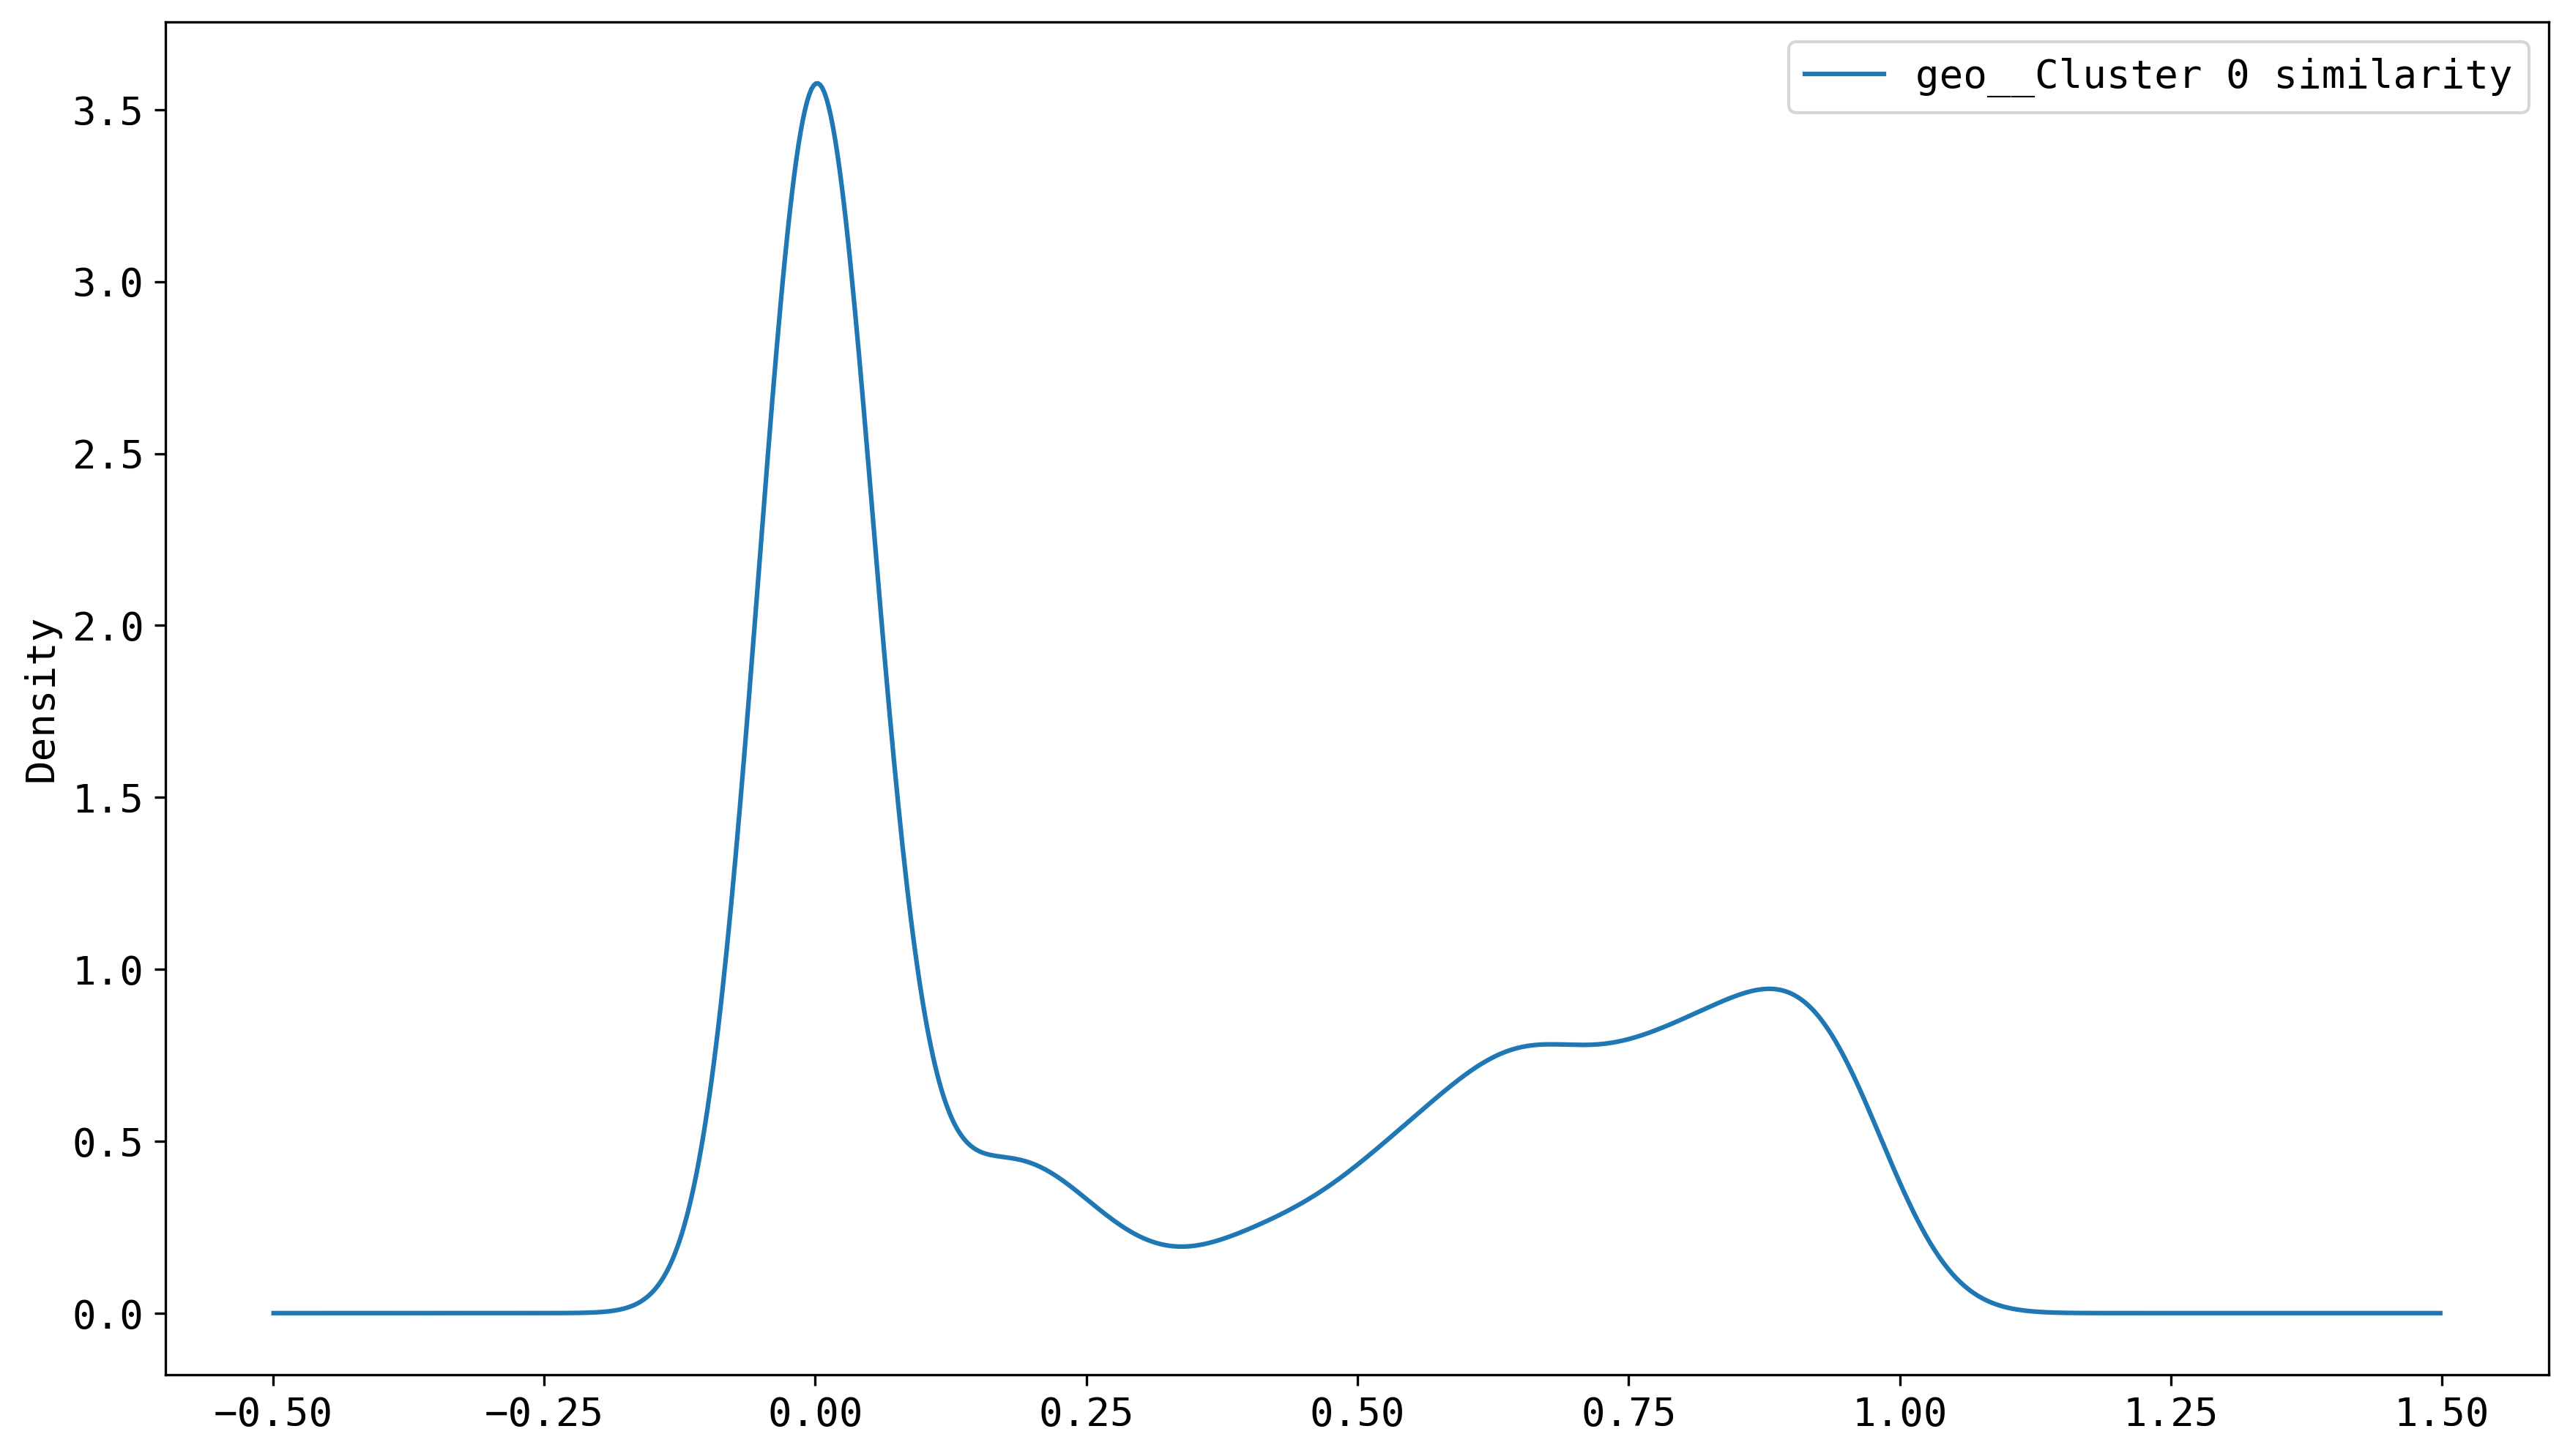

In [46]:
df_housing_prepared[["geo__Cluster 0 similarity"]].plot.kde()

## **MODEL SELECTION & TRAINING**

- **Linear Regression Model**

In [47]:
from sklearn.linear_model import LinearRegression

In [49]:
# since the last estimator is a predictor, this pipeline will behave like a predictor
lin_reg = make_pipeline(preprocessing, LinearRegression())

# in this case of a predictor, the value of y is necessary
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x73a...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilaritySearch(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat-simple-impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot-encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x73ac3b261100>)])),
                ('linearregression', LinearRegression())])

### **PREDICTIONS & EVALUATION**

In [93]:
housing_predictions = lin_reg.predict(housing)

p = housing_predictions[:5].round(2)
p

array([233377.99, 216864.45, 213955.33,  95690.79, 121651.35])

In [94]:
t = housing_labels[:5].values

t

array([181300., 153800., 179500.,  81300., 297100.])

In [95]:
for t, p in zip(*(t, p)):
    error = (abs(t-p))

    accuracy = (error/ t) * 100
    print(f"Error: {error.round(0)} with an accuracy of: {accuracy.round(0)}%")

Error: 52078.0 with an accuracy of: 29.0%
Error: 63064.0 with an accuracy of: 41.0%
Error: 34455.0 with an accuracy of: 19.0%
Error: 14391.0 with an accuracy of: 18.0%
Error: 175449.0 with an accuracy of: 59.0%


In [96]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [97]:
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [98]:
lin_rmse

np.float64(69151.25430236742)

The RMSE error is rather large which could possibly be a sign of **under fitting**

**SOLUTIONS**

- train a more complex model

- regularize the model

- perform feature engineering all again, to add better features.

## **A COMPLEX MODEL**

In [106]:
from sklearn.tree import DecisionTreeRegressor

In [107]:
tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(
        random_state=42))

tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x73a...
                                                  ClusterSimilaritySearch(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat-simple-impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot-encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x73ac3b261100>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [108]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [109]:
tree_rmse

np.float64(0.0)

The RMSE is zero, which could indicate **over fitting**; Since we can only use the **test set** to confirm this, AND we do not want the model to become ***fine-tuned to the test set***, we instead perform **CROSS-VALIDATION** for better evaluation.

## **CROSS VALIDATION**


1. split the training set into a smaller *new training set* and *validation set*.

2. utilize scikit-learn ***cross-validation*** feature; this will
   
   1.  split the training set into a stated number of *non-overlapping* subsets called ***FOLDs***.
   
   2.  train and evaluates the decision tree model [the number of splitting] times, picking different fold for evaluation every time, and using the remaining folds for training. It then outputs an array containing [stated number of splits] evaluation scores

In [110]:
from sklearn.model_selection import cross_val_score

In [116]:
lin_rmse = -cross_val_score(
    estimator=lin_reg,
    X=housing,
    y=housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

In [111]:
tree_rmse = -cross_val_score(
    estimator=tree_reg,
    X=housing,
    y=housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

In [119]:
rmse_df = pd.DataFrame({"linear_model": lin_rmse, "decision_tree_model": tree_rmse})

rmse_df

linear_model  decision_tree_model
0  68970.364786         65446.400212
1  69105.977976         63534.591794
2  68294.641087         63557.588413
3  69622.270901         70915.826721
4  80522.231753         69198.517794
5  68390.761873         65883.191461
6  75732.899203         66616.437881
7  67858.706686         66519.945011
8  70834.503135         69963.007078
9  72859.379123         66798.240887

In [120]:
rmse_df.describe()

linear_model  decision_tree_model
count     10.000000            10.000000
mean   71219.173652         66843.374725
std     4078.088218          2508.645943
min    67858.706686         63534.591794
25%    68535.662602         65555.598024
50%    69364.124439         66568.191446
75%    72353.160126         68598.448567
max    80522.231753         70915.826721

This indicates that the decision tree model over-fitted the data because the training error is zero while the validation error is high.

---

## **Random Forest Model**



In [121]:
from sklearn.ensemble import RandomForestRegressor

In [122]:
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

forest_rmses = -cross_val_score(
    estimator=forest_reg,
    X=housing,
    y=housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

In [123]:
rmse_df["random_forest_model"] = pd.Series(forest_rmses)

rmse_df

linear_model  decision_tree_model  random_forest_model
0  68970.364786         65446.400212         46794.470295
1  69105.977976         63534.591794         46645.434454
2  68294.641087         63557.588413         46479.365955
3  69622.270901         70915.826721         47890.722600
4  80522.231753         69198.517794         47790.126607
5  68390.761873         65883.191461         47455.764501
6  75732.899203         66616.437881         49451.861177
7  67858.706686         66519.945011         46608.746936
8  70834.503135         69963.007078         48062.864748
9  72859.379123         66798.240887         48367.869821

In [124]:
rmse_df.describe()

linear_model  decision_tree_model  random_forest_model
count     10.000000            10.000000            10.000000
mean   71219.173652         66843.374725         47554.722710
std     4078.088218          2508.645943           951.764779
min    67858.706686         63534.591794         46479.365955
25%    68535.662602         65555.598024         46682.693415
50%    69364.124439         66568.191446         47622.945554
75%    72353.160126         68598.448567         48019.829211
max    80522.231753         70915.826721         49451.861177

Of the three models, the Random Forest performs better than the others.

## **MODEL FINE-TUNING**

- Grid Search

- Randomized Search